In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_auc_score, plot_roc_curve, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from collections import Counter

In [2]:
## 4.1 Loading and Cleaning the Data for Comparative Modeling

df = pd.read_csv('data/PS_20174392719_1491204439457_log.csv')

# to make all columns camel case and labeled the same way
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})

# EDA indicated 3 columns were irrelevant:

df = df.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

# EDA indicated fraudulent transactions only occur in CASH_OUT and TRANSFER types

df = df[(df['type'] == 'CASH_OUT' ) | (df['type'] == 'TRANSFER')]

#engineered columns 
df['sourceBalanceDiff'] = df['newBalanceOrig'] + df['amount'] - df['oldBalanceOrig']
df['tarBalanceDiff'] = df['oldBalanceDest'] + df['amount'] - df['newBalanceDest']

df = pd.get_dummies(columns = ['type'], drop_first = True, data = df)

In [3]:
X = df.drop(columns = ['isFraud'])
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=42, 
                                                    stratify = y)

baseline = LogisticRegression()

In [4]:
baseline.fit(X_train, y_train)

LogisticRegression()

In [5]:
preds = baseline.predict(X_test)

In [6]:
preds

array([0, 0, 0, ..., 0, 0, 0])

In [7]:
baseline_cm = confusion_matrix(y_test, preds)

In [8]:
baseline_cm_df = pd.DataFrame(baseline_cm, columns = ['Predicted Legit', 'Predicted Fraud'], index = ['Actual Legit', 'Actual Fraud'])

In [9]:
baseline_cm_df

,Predicted Legit,Predicted Fraud
Actual Legit,689553,997
Actual Fraud,1183,870


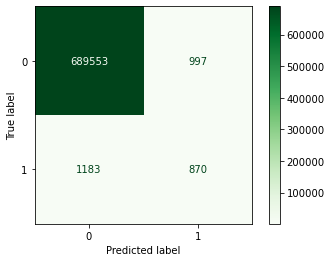

In [10]:
plot_confusion_matrix(baseline, X_test, y_test, cmap= 'Greens')

In [11]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [12]:
spec = tn/(tn + fp)
sense = tp/(tp+fn)
print(f"Specificity: {spec}")
print(f"Sensitivity: {sense}")

Specificity: 0.9985562233002679
Sensitivity: 0.4237700925474915


In [13]:
pred_proba = [i[1] for i in baseline.predict_proba(X_test)]
baseline_pred_df = pd.DataFrame({'true_values': y_test,
                                'pred_probs': pred_proba})
baseline_pred_df.head()

,true_values,pred_probs
5611919,0,4.095621e-25
4804226,0,4.361779e-07
5932106,0,2.754824e-14
3680497,0,5.768656e-12
1390325,0,2.390749e-34


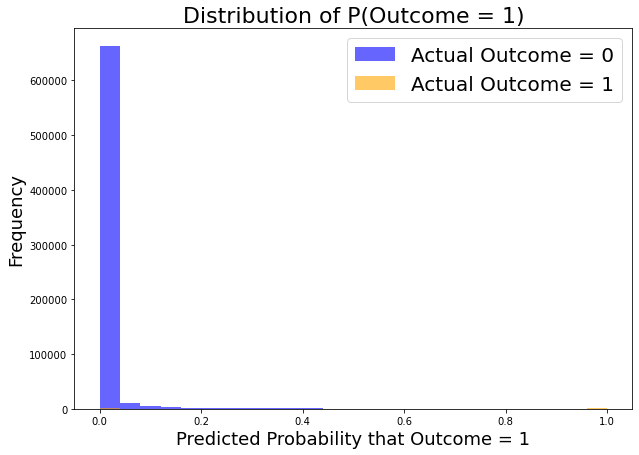

In [14]:
plt.figure(figsize = (10, 7))
plt.hist(baseline_pred_df[baseline_pred_df['true_values'] == 0]['pred_probs'],
         bins = 25,
         color = 'b',
         alpha = 0.6,
         label = 'Actual Outcome = 0')
plt.hist(baseline_pred_df[baseline_pred_df['true_values'] == 1]['pred_probs'],
         bins = 25,
         color = 'orange',
         alpha = 0.6,
         label = 'Actual Outcome = 1')

plt.title('Distribution of P(Outcome = 1)', fontsize = 22)
plt.ylabel('Frequency', fontsize = 18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize = 18)

plt.legend(fontsize = 20);

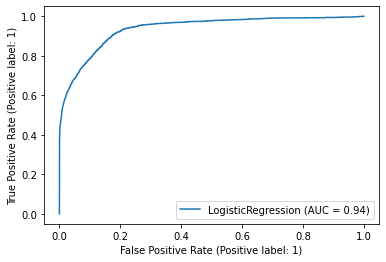

In [15]:
plot_roc_curve(baseline, X_test, y_test);

In [16]:
cross_val_score(baseline, X, y)

array([0.97531412, 0.99832877, 0.99820424, 0.99791728, 0.99775845])

In [17]:
accuracy_score(y_test, preds)

0.9968524537144656

Okay, the baseline isn't performing overly well, the AUC is 0.94, the accuracy is 99.7 % and in cross validation we're seeing some variation in the cross-validated accuracy.  For comparision, if we'd predicted everything was not fraudulent, we'd have an overall accuracy of 99.8%.  Because we're dealing with a highly unbalanced class here, we'll need to try out a few methods to see if we can improve the model.  

In [18]:
counter = Counter(y)
print(counter)

Counter({0: 2762196, 1: 8213})


In [19]:
oversample = SMOTE()
X1, y1 = oversample.fit_resample(X, y)

In [20]:
counter = Counter(y1)
print(counter)

Counter({1: 2762196, 0: 2762196})


In [21]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, random_state = 42)

os_lr = LogisticRegression()

os_lr.fit(X1_train, y1_train)

LogisticRegression()

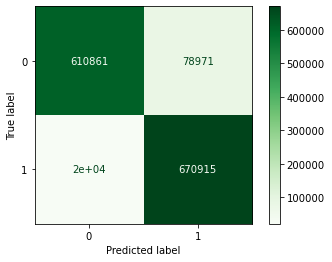

In [22]:
plot_confusion_matrix(os_lr, X1_test, y1_test, cmap= 'Greens')

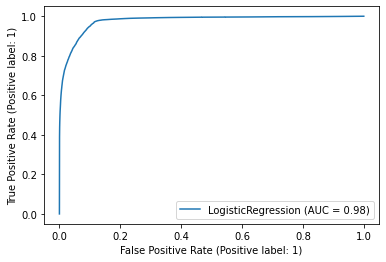

In [23]:
plot_roc_curve(os_lr, X1_test, y1_test);

In [24]:
cross_val_score(os_lr, X1_test, y1_test)

array([0.92884295, 0.92729346, 0.92821664, 0.92780728, 0.92781814])

In [25]:
preds1 = os_lr.predict(X1_test)
accuracy_score(y1_test, preds1)

0.9280847557523072

At first glance this looks like a regression from the previous set, but we need to keep in mind that this includes the minority cases being synthetically inflated through oversampling to match the same size as the majority case.

In [26]:
cross_val_score(os_lr, X_test, y_test)

array([0.99662867, 0.99691022, 0.99704016, 0.99709067, 0.99651314])

In [27]:
os_preds = os_lr.predict(X_test)
accuracy_score(y_test, os_preds)

0.8860877010350807

And we see a decrease in prediction accuracy when we test it on the non-oversampled data.  Interesting.  Let's try both over and undersampling, see if that improves our performance.

In [28]:
over = SMOTE(sampling_strategy = 0.1)
under = RandomUnderSampler(sampling_strategy = 0.5)
steps = [('o', over), ('u', under)]
balance_pipe = Pipeline(steps = steps)
X2, y2 = balance_pipe.fit_resample(X, y)
X2_train, X2_test, y2_train, y2_test = train_test_split(X1, y1, random_state = 42)

bal_lr = LogisticRegression()
bal_lrcv = LogisticRegressionCV()

bal_lr.fit(X2_train, y2_train)
bal_lrcv.fit(X2_train, y2_train)

LogisticRegressionCV()

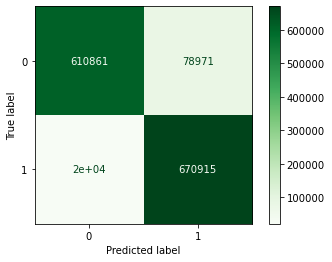

In [29]:
plot_confusion_matrix(bal_lr, X2_test, y2_test, cmap= 'Greens')

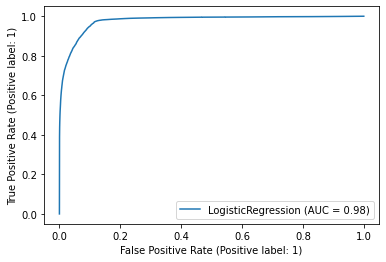

In [30]:
plot_roc_curve(bal_lr, X2_test, y2_test);

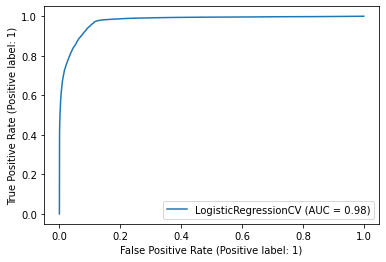

In [31]:
plot_roc_curve(bal_lrcv, X2_test, y2_test)

In [32]:
bal_preds1 = bal_lr.predict(X_test)
bal_preds2 = bal_lrcv.predict(X_test)

In [33]:
cross_val_score(bal_lr, X, y)

array([0.97531412, 0.99832877, 0.99820424, 0.99791728, 0.99775845])

In [34]:
accuracy_score(y_test, bal_preds1)

0.8860877010350807

In [35]:
cross_val_score(bal_lrcv, X, y)

In [ ]:
accuracy_score(y_test, bal_preds2)

So far, the SMOTE algorithm for both over and undersampling isn't performing as well as I would like.  Let's try some decision tree type models such as Random Forest and XGBoost, both with and without over/undersampling.

In [37]:
rfc = RandomForestClassifier()
rfc_o = RandomForestClassifier()
rfc_bal = RandomForestClassifier()

array([0.97503619, 0.99832516, 0.99820424, 0.99790103, 0.99775845])

0.8860877010350807

In [38]:
rfc.fit(X_train, y_train)
rfc_o.fit(X1_train, y1_train)
rfc_bal.fit(X2_train, y2_train)

In [ ]:
rfc_preds = rfc.predict(X_test)
rfc_o_preds = rfc_o.predict(X1_test)
rfc_bal_preds = rfc_bal.predict(X2_test)

Error: Session cannot generate requests

In [ ]:
cross_val_score(rfc, X_test, y_test)

array([0.99997112, 0.99997834, 0.99997834, 0.99997834, 0.99999278])

In [ ]:
rfc_train_preds = rfc.predict(X_train)

In [ ]:
accuracy_score(y_train, rfc_train_preds), accuracy_score(y_test, rfc_preds)

(1.0, 0.9999870055428579)

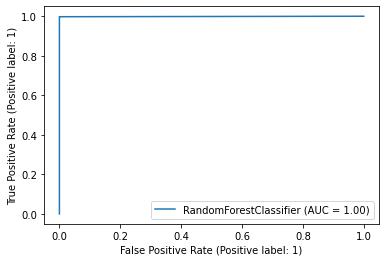

In [ ]:
plot_roc_curve(rfc, X_test, y_test)

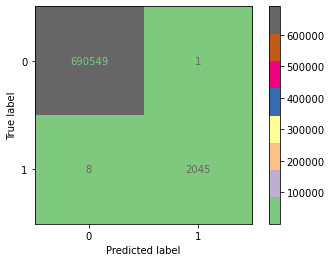

In [ ]:
plot_confusion_matrix(rfc, X_test, y_test, cmap = 'Accent')

In [ ]:
cross_val_score(rfc_o, X, y)

In [ ]:
cross_val_score(rfc_o, X, y)

array([0.99995308, 0.99998556, 1.        , 0.9999982 , 0.01055802])

In [ ]:
accuracy_score(y1_test, rfc_o_preds)

array([0.99992961, 0.99998556, 0.9999982 , 0.9999982 , 0.01053817])

array([0.99993142, 0.99998556, 1.        , 0.9999982 , 0.01053998])

0.9998957351324815

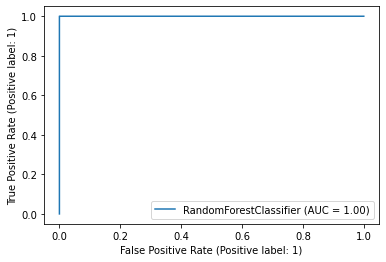

In [ ]:
plot_roc_curve(rfc_o, X1_test, y1_test)

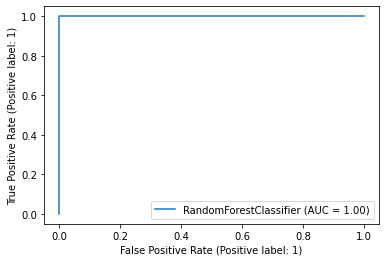

In [ ]:
plot_roc_curve(rfc_o, X_test, y_test)

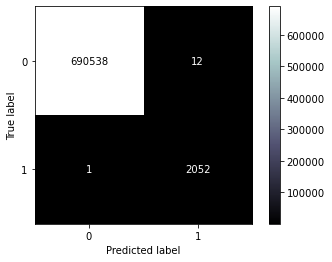

In [ ]:
plot_confusion_matrix(rfc_o, X_test, y_test, cmap='bone')

Now this is interesting.  Accepting the default RFC parameters and using artificial oversampling of the minority(fraudulent) class in model training, we've tuned to NO missed fraudulent samples.  For this scenario, we might be moving in the right direction.  Once we tune this model we might be able to reduce the total misclassifications to single digits on unseen data.

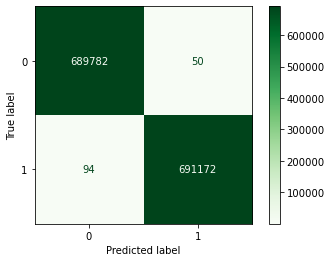

In [ ]:
plot_confusion_matrix(rfc_o, X1_test, y1_test, cmap ='Greens')